# Final Project DL model Notebook - sinple CNN model with two convolutional layers - v01

#### imports, settings and constants

run log: 

- AWS P2 instance
- full data set
- batch_size = 256
- epochs = 4
- learning_rate = 1e-4

In [1]:
import sys

from keras.models import Sequential
from keras.layers import BatchNormalization, Flatten, Dense, Conv2D, MaxPooling2D
from keras.optimizers import Adam
import numpy as np

from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils import *

current_dir = Path.cwd()
HOME_DIR = current_dir.parent
DATA_DIR = HOME_DIR.joinpath('data')

# comment out one of the two path options to toggle between sample directory and all data
path = DATA_DIR
# path = DATA_DIR.joinpath('sample')
train_path = path.joinpath('train')
val_path = path.joinpath('valid')
test_path = path.joinpath('test')
results_path = path.joinpath('tesults')

# training variables
batch_size = 256
epochs = 4
learning_rate = 1e-4

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


#### getting training and validation data in batches

In [2]:
batches = get_in_batches(train_path, batch_size=batch_size)
val_batches = get_in_batches(val_path, batch_size=batch_size)
test_batches = get_in_batches(test_path, batch_size=batch_size)

Found 22424 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


#### and getting the classes, labels and filenames for each batch

In [3]:
trn_classes = batches.classes
val_classes = val_batches.classes
trn_labels = onehot(batches.classes)
val_labels = onehot(val_batches.classes)
trn_filenames = batches.filenames
val_filenames = val_batches.filenames

#### defining CNN model

In [4]:
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3, 224, 224)),
            Conv2D(32, 3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Conv2D(64, 3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3, 3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(10, activation='softmax')
    ])
model.compile(Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3, 224, 224)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 222, 222)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 222, 222)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 74, 74)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 72, 72)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 72, 72)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 24, 24)        0         
__________

#### fit_generator() consuming the batches provided by the ImageDataGenerator to fit the model to the data

batches.n = samples in the dataset

batches.batch_size = number of samples in a batch

using batches.n // batches.batch_size ensures we go over the entire dataset once per epoch

validation_steps = number of batches of samples to validate against

In [5]:
history = model.fit_generator(batches,
                    steps_per_epoch=batches.n//batches.batch_size,
                    validation_data=val_batches,
                    validation_steps=1,
                    epochs=epochs)

Epoch 1/4
87/87 [==============================] - 184s - loss: 0.3276 - acc: 0.9134 - val_loss: 1.5905 - val_acc: 0.3945
Epoch 2/4
87/87 [==============================] - 181s - loss: 0.0202 - acc: 0.9979 - val_loss: 1.1785 - val_acc: 0.7227
Epoch 3/4
87/87 [==============================] - 182s - loss: 0.0077 - acc: 0.9997 - val_loss: 0.6126 - val_acc: 0.8555
Epoch 4/4
87/87 [==============================] - 181s - loss: 0.0044 - acc: 0.9999 - val_loss: 0.2017 - val_acc: 0.9688


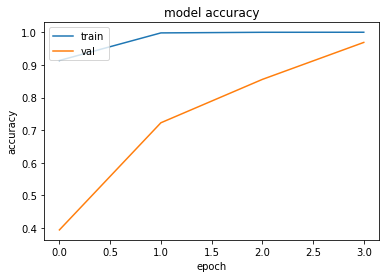

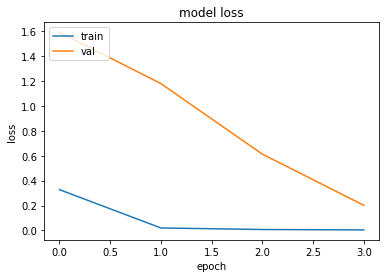

In [6]:
plot_acc_and_loss(history)

#### validating the model performance on the val set

Running the evaluate generator returns the cost and accuracy of the model. Doing it in a loop allows us to confirm that the performance is stable. Results should be very similar for all runs

In [7]:
"""
rnd_batches = get_in_batches(val_path, batch_size=batch_size, shuffle=True)
val_res = [model.evaluate_generator(rnd_batches, rnd_batches.samples) for i in range(2)]
print(np.round(val_res, 3))
"""

'\nrnd_batches = get_in_batches(val_path, batch_size=batch_size, shuffle=True)\nval_res = [model.evaluate_generator(rnd_batches, rnd_batches.samples) for i in range(2)]\nprint(np.round(val_res, 3))\n'

#### test performance and plot confusion matrix on one batch of 200 images

In [47]:
test_set = get_in_batches(val_path, shuffle=False, class_mode=None, batch_size=batch_size)
pred_classes = model.predict_generator(test_set, 1)
pred_classes = np.argmax(pred_classes, axis=1)
act_classes = test_set.classes

Found 5000 images belonging to 10 classes.


AxisError: axis 1 is out of bounds for array of dimension 1

In [31]:
cm = confusion_matrix(act_classes, pred_classes)
plot_confusion_matrix(cm, val_batches.class_indices)
plt.figure()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [5000, 256]

In [ ]:
model.optimizer.lr = 1e-5
history = model.fit_generator(batches,
                    steps_per_epoch=batches.batch_size,
                    validation_data=val_batches,
                    validation_steps=val_batches.batch_size,
                    epochs=epochs)

In [ ]:
plot_acc_and_loss(history)

In [ ]:
rnd_batches = get_in_batches(val_path, batch_size=batch_size, shuffle=True)
val_res = [model.evaluate_generator(rnd_batches, rnd_batches.samples) for i in range(3)]
np.round(val_res, 3)
print(val_res)

In [ ]:
test_set = get_in_batches(val_path, shuffle=False, class_mode=None, batch_size=200)
pred_classes = model.predict_generator(test_set, 1)
pred_classes = np.argmax(pred_classes, axis=1)
act_classes = test_set.classes

In [ ]:
cm = confusion_matrix(act_classes, pred_classes)
plot_confusion_matrix(cm, val_batches.class_indices)
plt.figure()
plt.show()

In [ ]:
pred_classes

In [ ]:
act_classes